# Модерация отзывов

## Введение

**Цель проекта**

Разработать решение для выявления токсичных комментариев, чтобы отправлять их на модерацию. 

**Задачи проекта**
1. Разработка нескольких моделей для классификации комментариев как не_токсичные и токсичные. 
2. Выбор лучшей модели.

**Критерии качества моделей:**
- Качество предсказания: значение метрики F1 < 0.75.
____

**О данных**

**Датасет data** содержит комментарии с разметкой их токсичности.
- text - текст комментария.
- toxic - классификация токсичности: 0 - не_токсичный, 1 - токсичный.

**toxic** является целевым признаком для моделей.
_____

**План проекта**
1. Обзор и предобработка данных
2. Исследовательский анализ данных
3. Обучение и выбор моделей
4. Общий вывод

## Импорт библиотек

In [1]:
#установим библиотеки для работы

!pip install transformers[torch] -q
!pip install datasets -q
!pip install -U sentence-transformers -q
!pip install tf-keras -q


In [2]:
#импортируем библиотеки для работы
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from datasets import Dataset
from torch.utils.data import Dataset as TorchDataset, DataLoader

import torch
import torch.nn.functional as F
import transformers
from transformers import (DistilBertTokenizer, 
DistilBertForSequenceClassification, 
Trainer, 
TrainingArguments, 
AutoTokenizer, 
AutoModel,
AutoModelForSequenceClassification)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from tqdm import tqdm
import os
import gc


#задаем константы
RANDOM_STATE = 30
BATCH_SIZE = 16

C:\Users\user\anaconda3\envs\practicum\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\user\anaconda3\envs\practicum\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\user\anaconda3\envs\practicum\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the genc

## Функции для работы

In [3]:
#разгонятель тоски
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#для загрузки данных
class TextDataset(TorchDataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoded = self.tokenizer(text,
                                 truncation=True,
                                 padding='max_length',
                                 max_length=self.max_len,
                                 return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0)
        }

In [5]:
#для извлечения CLS-токена
def extract_cls_embeddings(dataloader, model, device):
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting CLS embeddings"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings, dim=0).numpy()

In [6]:
#для токенизации в DistilBertForSequenceClassification
def tokenizator3000(example):
    return tokenizer(example['text'],
                     max_length=512,
                     truncation=True,
                     padding="max_length")

In [7]:
#для токенизации в ToxicBert
def tokenizer3000toxic(batch):
    return tokenizer_toxic(batch["text"], 
                           truncation=True, 
                           padding="max_length", 
                           max_length=300)

In [8]:
#для оценки в DistilBertForSequenceClassification
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {"f1": f1_score(labels, preds)}

In [9]:
#для оценки в ToxicBert
def compute_metrics_toxic(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"f1": f1_score(labels, preds)}

## Предобработка данных

### Импорт и обзор данных

In [10]:
#импортируем данные
try:
    data = pd.read_csv('Desktop/practicum cases/toxic_comments.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [11]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [12]:
data.sample(10)

,Unnamed: 0,text,toxic
75223,75299,How's about this... Editing in such a way that...,0
53815,53876,Moi? Vandalize? I was out of reverts anyway. A...,0
73983,74055,"Trust is earned, not given freely. You have bu...",0
100437,100534,ACS \n\nThe ACS clearly sets the standard in t...,0
86435,86516,"For the record, U-Haul pickup trucks and cargo...",0
119567,119672,"Oi Wankstain ==\n\nFuck off you ignorant cunt,...",1
30561,30601,Find some facts about a town or subject around...,0
31055,31095,"As I understand it, her historical campaign st...",0
62584,62651,O&A; and thirtysomething \n\nThe article alude...,0
56506,56567,YOU WONT BAN ME YOU FAGGG \n ==,1


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [14]:
print('Кол-во явных дубликатов:', data.duplicated().sum())

Кол-во явных дубликатов: 0


In [15]:
print('Кол-во явных дубликатов в столбце текстов:', data['text'].duplicated().sum())

Кол-во явных дубликатов в столбце текстов: 0


In [16]:
print('Кол-во пропусков:')
data.isna().sum()

Кол-во пропусков:


Unnamed: 0    0
text          0
toxic         0
dtype: int64

**Итог обзора данных**
- Тип данных ок.
- Явных дубликатов нет, в т.ч. конкретно в столбце текстов.
- Пропусков нет.
- Столбец 'Unnamed: 0' имеет загадочное название и назначение, но он очень похож на набор старых индексов до предобработки текста. Т.к. он нам в работе не понадобится, мы его удалим.
____

**План по предобработке**
- Удалить ненужный столбец.
- Привести все тексты к нижнему регистру, чтобы проверить еще раз на дубликаты, менее явные.
- ***Так как предобработку данных для моделей мы будем проделывать с фреймворками на базе Bert/токенизатором Bert, мы оставим знаки препинания и стоп-слова на месте.***

### Коррекция данных

In [17]:
#удалим ненужный столбец
data = data.drop('Unnamed: 0', axis=1)
#приведем тексты к нижнему регистру
data['text'] = data['text'].str.lower()

#проверим на дубликаты
print('Кол-во явных дубликатов после коррекции:', data.duplicated().sum())
print('Кол-во явных дубликатов после коррекции в столбце текстов:', data['text'].duplicated().sum())

Кол-во явных дубликатов после коррекции: 45
Кол-во явных дубликатов после коррекции в столбце текстов: 46


- Это очень интересный результат, который намекает, что есть дубликаты текста, которые помечены по-разному в части токсичности.

In [18]:
#удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)
#посмотрим на коварную ошибку разметки
data.loc[data['text'].duplicated(keep=False)]

,text,toxic
80528,removing irrelevant nonsense\n\nad hominem att...,1
135364,removing irrelevant nonsense\n\nad hominem att...,0


In [19]:
#мы смотрим на данные с ошибками и не осуждаем - мы удаляем то, что требует осуждения или "помилования"
data = data.drop(index = [80528, 135364], axis=0).reset_index(drop=True)

### Выводы по предобработке

- Тип данных ок.
- Пропусков нет.
- Тексты были приведены к нижнему регистру.
- Был удален нерелевантный столбец 'Unnamed: 0'.
- Были удалены 45 полных дубликатов и 2 строчки с одинаковым текстом, но разными метками 'toxic'.

## Исследовательский анализ данных

### Оценка распределения длины отзывов

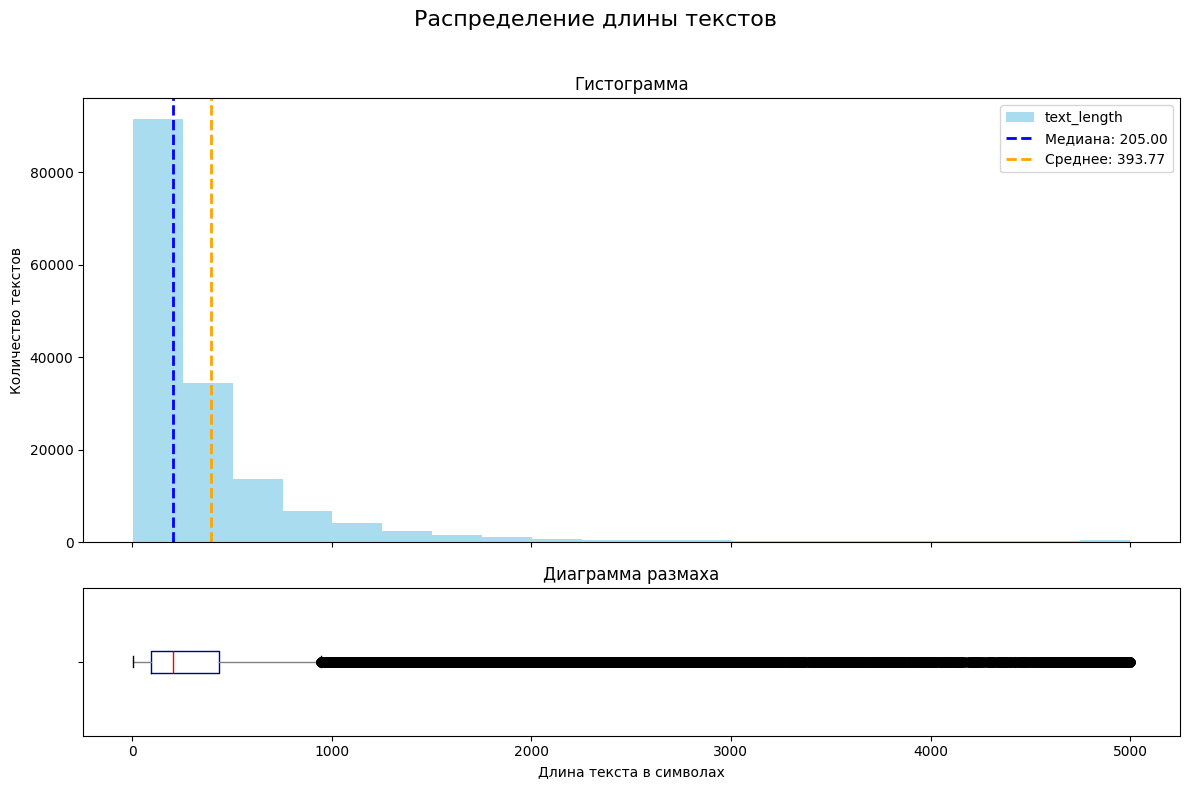

In [20]:
data['text_length'] = data['text'].str.len()

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1])]
fig.suptitle("Распределение длины текстов", fontsize=16)

palette = ['#87CEEB', '#4682B4', '#1E90FF', '#00BFFF', '#00CED1', '#40E0D0', '#468499', '#B0E0E6', '#66CDAA', '#6495ED']

# Гистограмма
data['text_length'].plot(
    kind='hist',
    alpha=0.7,
    ax=axes[0],
    color=palette[0],
    bins=20)
axes[0].set_ylabel('Количество текстов')
axes[0].set_title("Гистограмма")
axes[0].set_xticklabels([])

median = data['text_length'].median()
mean = data['text_length'].mean()
axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
axes[0].legend()

# Боксплот
data['text_length'].plot(
    kind='box',
    ax=axes[1],
    vert=False,
    color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'})
axes[1].set_xlabel('Длина текста в символах')
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
axes[1].set_title("Диаграмма размаха")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


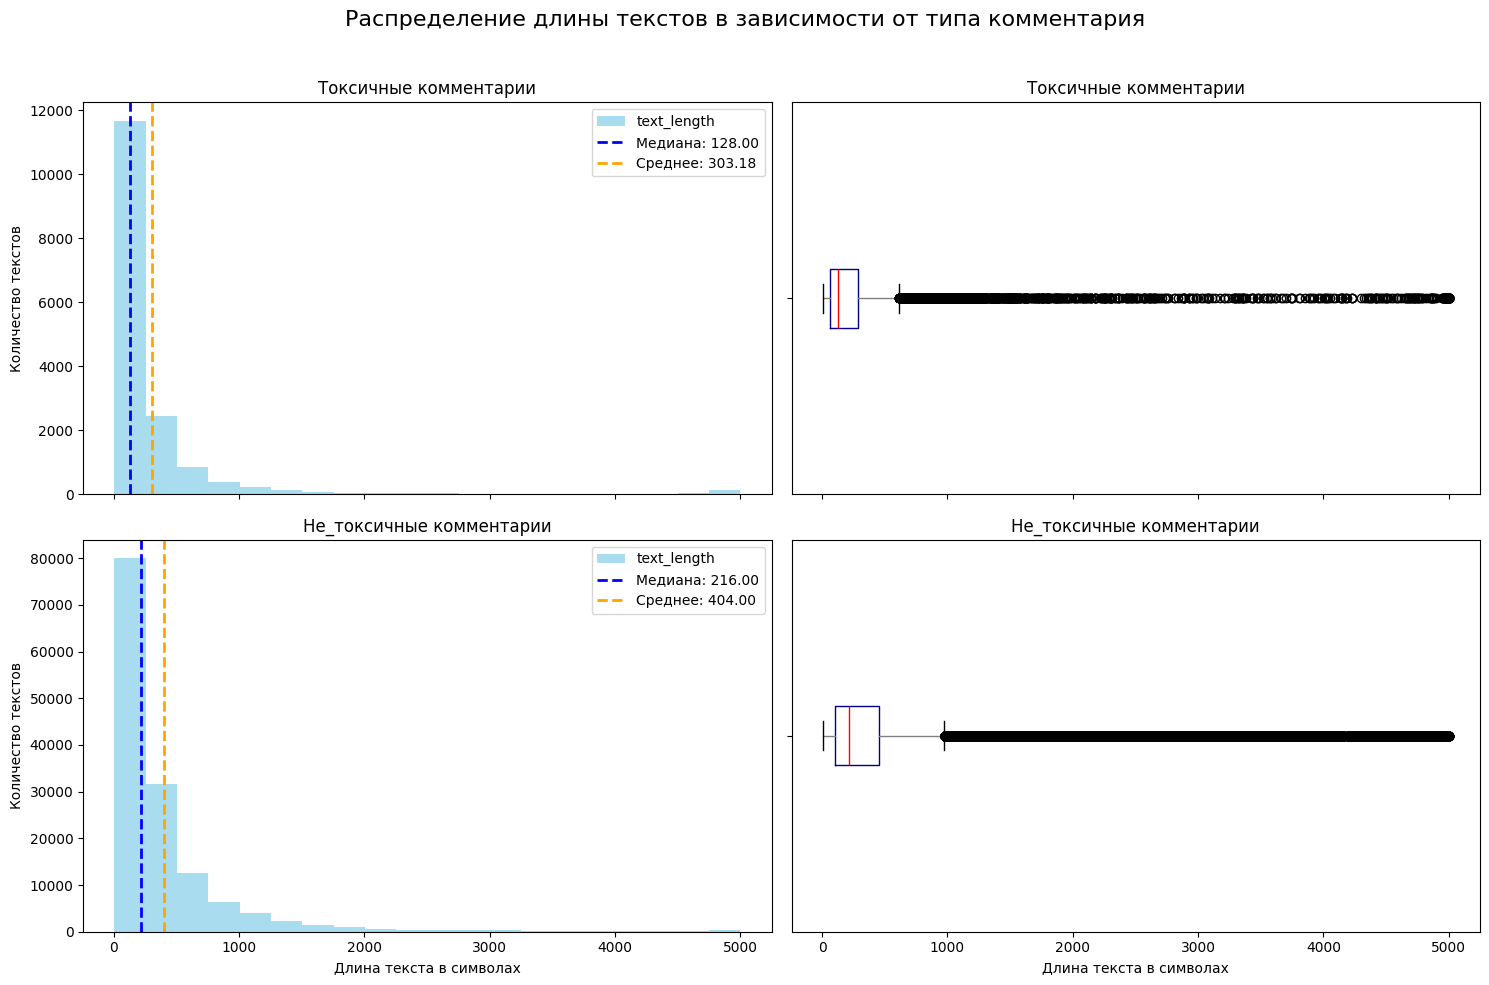

In [21]:
data_toxic = data.query('toxic == 1')
data_non_toxic = data.query('toxic == 0')

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2]) 

axes = [fig.add_subplot(gs[0]), fig.add_subplot(gs[1]), fig.add_subplot(gs[2]), fig.add_subplot(gs[3]),]
fig.suptitle("Распределение длины текстов в зависимости от типа комментария", fontsize=16)

palette = ['#87CEEB', '#4682B4', '#1E90FF', '#00BFFF', '#00CED1', '#40E0D0', '#468499', '#B0E0E6', '#66CDAA', '#6495ED']

# Гистограммы
data_toxic['text_length'].plot(
    kind='hist',
    alpha=0.7,
    ax=axes[0],
    color=palette[0],
    bins=20)
axes[0].set_ylabel('Количество текстов')
axes[0].set_title("Токсичные комментарии")
axes[0].set_xticklabels([])

median = data_toxic['text_length'].median()
mean = data_toxic['text_length'].mean()
axes[0].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
axes[0].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
axes[0].legend()

data_non_toxic['text_length'].plot(
    kind='hist',
    alpha=0.7,
    ax=axes[2],
    color=palette[0],
    bins=20)
axes[2].set_ylabel('Количество текстов')
axes[2].set_title("Не_токсичные комментарии")
axes[2].set_xlabel('Длина текста в символах')


median = data_non_toxic['text_length'].median()
mean = data_non_toxic['text_length'].mean()
axes[2].axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана: {median:.2f}')
axes[2].axvline(mean, color='orange', linestyle='dashed', linewidth=2, label=f'Среднее: {mean:.2f}')
axes[2].legend()

# Боксплоты
data_toxic['text_length'].plot(
    kind='box',
    ax=axes[1],
    vert=False,
    color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'})
axes[1].set_yticklabels([])
axes[1].set_ylabel('')
axes[1].set_title('Токсичные комментарии')
axes[1].set_xticklabels([])


data_non_toxic['text_length'].plot(
    kind='box',
    ax=axes[3],
    vert=False,
    color={'boxes': 'DarkBlue', 'whiskers': 'gray', 'medians': 'red', 'caps': 'black'})
axes[3].set_xlabel('Длина текста в символах')
axes[3].set_yticklabels([])
axes[3].set_ylabel('')
axes[3].set_title("Не_токсичные комментарии")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [22]:
len(data.query('text_length > 1000'))

13323

- Медиана длины всех текстов - 205 знаков. Из-за хвоста графоманов среднее отличается от медианы почти вдвое - 394.
- Если смотреть по типам комментариев, то адекватный комментарий и по среднему значению, и по медиане вдвое длиннее токсичного.
- Однако, в целом комментарии больше 1000 знаков - это и довольно редкий случай (10% всего датасета), и малоинформативный избыток. Идея "длинный комментарий скорее всего добрый" может считаться уже с 600-700 знаков: больше 600-700 знаков - аномалия для токсичного, но норма для адекватного комментария.
- Пласт графоманов мы не будем отсекать от датасета (хотя тоже не велика потеря была бы), т.к. формально он не ошибка, такое бывает - зато будем уверенно использовать DistilBertTokenizer с ограничением max_length=512.

### Проверка баланса классов в целевом признаке

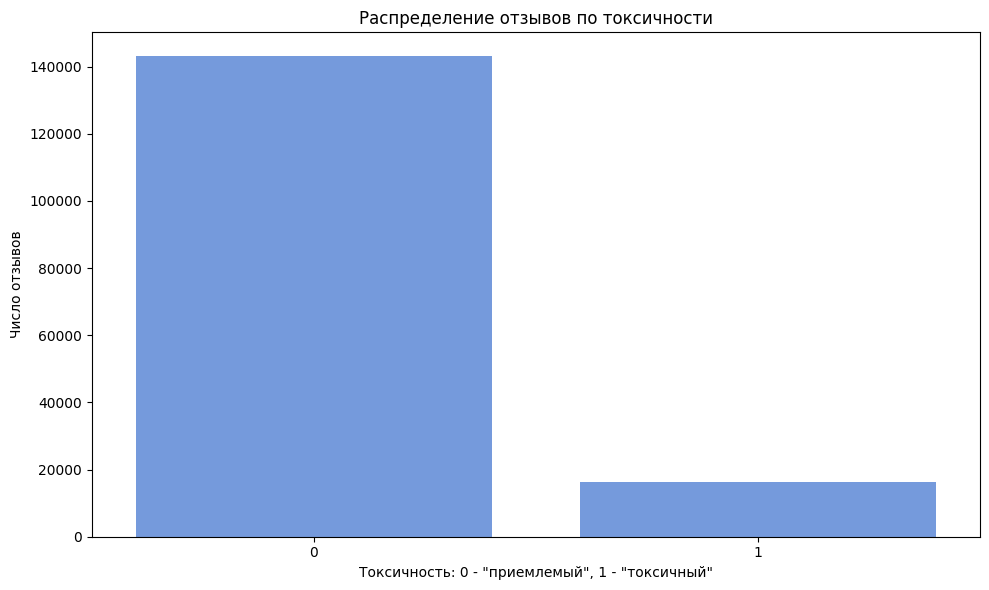

In [23]:
plt.figure(figsize=(10, 6)) 
sns.countplot(x='toxic', data=data, color='#6495ED')
plt.ylabel('Число отзывов')
plt.xlabel('Токсичность: 0 - "приемлемый", 1 - "токсичный"')
plt.title('Распределение отзывов по токсичности')
plt.tight_layout()
plt.show();

In [24]:
data['toxic'].value_counts()

toxic
0    143075
1     16170
Name: count, dtype: int64

- Токсичных отзывов чуть больше 10% от общего числа.
- Такой дисбаланс ожидаем и нормален, однако, его надо учесть при дальнейшей работе.

### Выводы по исследовательскому анализу

- Токсичные комментарии обычно почти вдвое короче - по медиане и по среднему значению, - чем не_токсичные комментарии.
- Наблюдается длинный, но немногочисленный хвост нетипично длинных отзывов. Трогать его пока без нужды не будем: посмотрим на работу моделей + DistilBertTokenizer сам какую-то часть отсечет из-за внутреннего порога.
- Наблюдается заметный дисбаланс классов у целевого признака: токсичными являются чуть больше 10% отзывов, а остальные - обычные.
  В дальнейшем мы учтем эту особенность:
  - стратифицируем выборки
  - при необходимости (в зависимости от результатов) уточним class_weight или еще что похуже

## Создание моделей

Для решения задачи мы обучим две модели и применим два способа обработки данных.
- Модель LogisticRegression мы обучим и проверим на данных, обработанных с помощью ToxicBert.
- Модель DistilBertForSequenceClassification мы обучим и проверим на данных, обработанных с соответствующим токенайзером.
___________

***Из-за специфики работы с Trainer для DistilBertForSequenceClassification, мы формально дважды разобьем данные на выборки, но это будут абсолютно идентичные выборки - за счет одинакового random_state.***

__________
***Мы воздержимся от LabelEncoder***, т.к. у нас признаки уже красивые, числовые и бинарные: 0 - "нет, не токсичный", 1 - "да, токсичный".

### Модель LogisticRegression

- Разобьем данные на тренеровочную, валидационную и тестовую выборки с учетом дисбаланса целевого признака.
- Токенизируем с помощью автотокенизатора на базе ToxicBert, а потом получим эмбеддинги CLS-токена по версии модели ToxicBert.
- Обучим модель LogisticRegression на эмбеддингах и проверим метрику F1 ее на валидационных данных.

#### Разбиение на выборки

In [25]:
X = data['text'].values
y = data['toxic'].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=RANDOM_STATE)


print('Размеренность входных данных:', X.shape[0])
print('Размеренность тренеровочных данных:', X_train.shape[0])
print('Размеренность валидационных данных:', X_val.shape[0])
print('Размеренность тестовых данных:', X_test.shape[0])

Размеренность входных данных: 159245
Размеренность тренеровочных данных: 127396
Размеренность валидационных данных: 15924
Размеренность тестовых данных: 15925


#### Обработка данных с ToxicBert

In [26]:
#инициируем модель и токейназер, специализированные для токсичных текстов
tokenizer = AutoTokenizer.from_pretrained('unitary/toxic-bert')
model = AutoModel.from_pretrained('unitary/toxic-bert').to(device)

#обрабатываем данные для модели
train_dataset = TextDataset(X_train, tokenizer)
val_dataset = TextDataset(X_val, tokenizer)
test_dataset = TextDataset(X_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_embeddings = extract_cls_embeddings(train_loader, model, device)
val_embeddings = extract_cls_embeddings(val_loader, model, device)
test_embeddings = extract_cls_embeddings(test_loader, model, device)

#проверим размеренность
print('Размеренность тренеровочных данных:', train_embeddings.shape)
print('Размеренность валидационных данных:', val_embeddings.shape)
print('Размеренность тестовых данных:', test_embeddings.shape)

C:\Users\user\anaconda3\envs\practicum\lib\site-packages\torch\nn\modules\module.py:1747: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Extracting CLS embeddings: 100%|█████████████████████████████████████████████████████| 996/996 [01:29<00:00, 11.16it/s]

Размеренность тренеровочных данных: (127396, 768)
Размеренность валидационных данных: (15924, 768)
Размеренность тестовых данных: (15925, 768)


#### Обучение и валидация LogisticRegression

In [27]:
#инициация и обучение модели логистической регрессии
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(train_embeddings, y_train)

#проверка модели на валидационных данных
prediction_lr_val = model_lr.predict(val_embeddings)
f1_prediction_lr_val = f1_score(y_val, prediction_lr_val)
print('Значение F1 для модели LogisticRegression на валидационных данных:', f1_prediction_lr_val)

Значение F1 для модели LogisticRegression на валидационных данных: 0.9363037339190461


- Отличная метрика F1, равная 0.94.
- Модель быстро учится.
- Удобно настраивать порог токсичности.

### Модель DistilBertForSequenceClassification

- Разобьем данные на тренеровочную, валидационную и тестовую выборки с учетом дисбаланса целевого признака.
- Токенизируем данные с DistilBertTokenizer.
- Обучим с помощью Trainer модель DistilBertForSequenceClassification.

#### Разбиение на выборки

In [28]:
#разобьем данные на тренеровочные и обучающие с учетом дисбаланса признаков
train, temp = train_test_split(data[['text', 'toxic']],
                               test_size = 0.2,
                               random_state=RANDOM_STATE ,
                               stratify=data['toxic'])

val, test = train_test_split(temp,
                             test_size = 0.5,
                             random_state=RANDOM_STATE,
                             stratify=temp['toxic'])


train = Dataset.from_pandas(train.rename({'toxic': 'labels'},
                                         axis=1)).class_encode_column("labels")
val = Dataset.from_pandas(val.rename({'toxic': 'labels'},
                                         axis=1)).class_encode_column("labels")
test = Dataset.from_pandas(test.rename({'toxic': 'labels'},
                                       axis=1)).class_encode_column("labels")

#проверим размеренность
print('Размеренность входных данных:', data.shape[0])
print('Размеренность тренеровочных данных:', train.shape[0])
print('Размеренность валидационных данных:', val.shape[0])
print('Размеренность тестовых данных:', test.shape[0])

Stringifying the column:   0%|          | 0/127396 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/127396 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/15924 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/15924 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/15925 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/15925 [00:00<?, ? examples/s]

Размеренность входных данных: 159245
Размеренность тренеровочных данных: 127396
Размеренность валидационных данных: 15924
Размеренность тестовых данных: 15925


#### Токенизация данных с DistilBertTokenizer

In [29]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_tokenized = train.map(tokenizator3000, batched=True)
val_tokenized = val.map(tokenizator3000, batched=True)
test_tokenized = test.map(tokenizator3000, batched=True)

Map:   0%|          | 0/127396 [00:00<?, ? examples/s]

Map:   0%|          | 0/15924 [00:00<?, ? examples/s]

Map:   0%|          | 0/15925 [00:00<?, ? examples/s]

#### Обучение и валидация модели DistilBertForSequenceClassification

In [30]:
#сейчас мы всё сломаем - всё в себе

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

training_args = TrainingArguments(
    output_dir='./model',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    save_strategy='epoch',
    save_total_limit=1,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    eval_strategy='epoch',
    metric_for_best_model='f1')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics)

trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_24232\1741711534.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,F1
1,0.078300,0.090809,0.844956
2,0.045200,0.105361,0.848939


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



TrainOutput(global_step=15926, training_loss=0.0828590019255536, metrics={'train_runtime': 9377.8047, 'train_samples_per_second': 27.17, 'train_steps_per_second': 1.698, 'total_flos': 3.375163343835955e+16, 'train_loss': 0.0828590019255536, 'epoch': 2.0})

In [31]:
f1_prediction_db_val = trainer.evaluate()
print('Значение F1 для модели DistilBertForSequenceClassification на валидационных данных:', f1_prediction_db_val['eval_f1'])

Значение F1 для модели DistilBertForSequenceClassification на валидационных данных: 0.8489388264669163


- Хорошая метрика F1, равная 0.85.
- Модель относительно долго обучается (хотя в сравнении с полнокровной Toxic Bert - пуля).

### Сравнительный анализ 

In [32]:
#соберем данные в табличку
models_comparison = pd.DataFrame({'Модель': ['Logistic Regression', 'DistilBertForSequenceClassification'],
                                  'F1 на валидационной выборке': [round(f1_prediction_lr_val, 2), round(f1_prediction_db_val["eval_f1"], 2)]})

models_comparison

,Модель,F1 на валидационной выборке
0,Logistic Regression,0.94
1,DistilBertForSequenceClassification,0.85


- На валидационных данных значительно лучше себя показала модель LogisticRegression.

### Тест и анализ выбранной модели

In [34]:
#оценим метрику на тестовой выборке
prediction_lr_test = model_lr.predict(test_embeddings)
f1_prediction_lr_test = f1_score(y_test, prediction_lr_test)
print('Значение F1 для модели LogisticRegression на валидационных данных:', f1_prediction_lr_test)

Значение F1 для модели LogisticRegression на валидационных данных: 0.9383025367992484


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14308
           1       0.95      0.93      0.94      1617

    accuracy                           0.99     15925
   macro avg       0.97      0.96      0.97     15925
weighted avg       0.99      0.99      0.99     15925



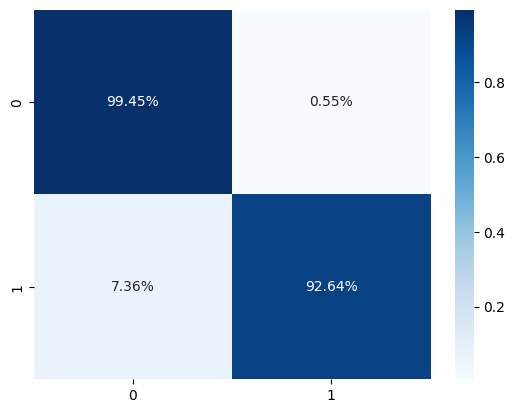

In [35]:
#посмотрим, где и как модель ошибается
print(classification_report(y_test, prediction_lr_test))

sns.heatmap(confusion_matrix(y_test, prediction_lr_test, normalize='true'),
            annot=True,
            fmt='0.2%',
            cmap='Blues')
plt.show()

- Модель имеет прекрасный-стабильный показатель F1 на тестовой выборке - 0.94.
- Модель в целом отлично справляется с идентификацией не_токсичных комментариев, однако делает 7.36% ошибок второго типа.
- Для улучшения результатов в части полноты выявления токсичных комментариев можно скорректировать порог идентификации комментария как токсичного (однако, это скорее пойдет в ущерб точности выявления нетоксичных комментариев и создаст дополнительную нагрузку на проверяющих).

### Выводы по созданию моделей

- Рекомендуемая по результатам обучения и валидации модель - LogisticRegression.
- F1 рекомендуемой модели на валидационных и тестовых данных равен 0.94, что выше заявленного порогового значения 0.75.

## Общие выводы

**Ход проекта**
1. **Обзор и предобработка данных**
   - Значительных минусов или аномалий в данных не выявлено.
   - Был удален нерелевантный столбец 'Unnamed: 0'.
   - Были удалены 45 полных дубликатов и 2 строчки с одинаковым текстом, но разными метками 'toxic'.
2. **Исследовательский анализ данных**
   - Токсичные комментарии обычно почти вдвое короче - по медиане и по среднему значению, - чем не_токсичные комментарии.
   - В целом комментарии больше 1000 знаков редкость (10% всех данных), особенно для токсичных комментариев, но они вполне реальны и достоверны. Их отсекать мы не стали.
   - В данных есть ожидаемый и заметный дисбаланс классов у целевого признака: токсичными являются чуть больше 10% отзывов, а остальные - обычные. Мы учли это при разбиении данных на выборки для обучения и теста моделей.
3. **Обучение и выбор моделей**
   - Были обучены две модели: LogisticRegression и DistilBertForSequenceClassification.
   - Рекомендуемая по результатам обучения и валидации модель - LogisticRegression.
   - F1 рекомендуемой модели на валидационных и тестовых данных равен 0.94, что выше заявленного порогового значения 0.75.
   - Модель в целом отлично справляется с идентификацией не_токсичных комментариев, однако делает 7.36% ошибок второго типа - т.е. идентифицирует токсичные комментарии как не_токсичные.
   - Для улучшения результатов в части полноты выявления токсичных комментариев можно скорректировать порог идентификации комментария как токсичного.
